In [7]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, Plots, CSV, DataFrames, SpecialFunctions
import Base: diff

# Trogdon Code
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

F = c -> -1 .* mfft(mifft(c) .* mifft(D*c))
F = c -> -1 .* mfft(mifft(D*c) .* integrate(c) .+ mifft(c).^2)

#33 (generic function with 1 method)

In [8]:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

In [9]:
function rk4(a, Mats, dt) 
    D3_dt = Mats[1]
    D3_3dt2 = Mats[2]
    D3_2dt = Mats[3]
    iD3_dt = Mats[4]
    iD3_3dt2 = Mats[5]
    iD3_2dt = Mats[6]
    f1 = D3_dt * F(iD3_dt * a)
    f2 = D3_3dt2 * F(iD3_3dt2 * (a+(dt/2)*f1))
    f3 = D3_3dt2 * F(iD3_3dt2 * (a+(dt/2)*f2))
    f4 = D3_2dt * F(iD3_2dt * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [10]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end 

In [11]:
# input: vector c of Fourier coefficients of a function
# variables defined outside of function: L,c_,n,X,m,iD
# output: vector q of function values of the antiderivative of the function
function integrate(c)
    ind = findfirst(n .== 0)
    S = iD*c
    q = c[ind]/m .* (X .+ L) + mifft(S)
    q = q .- q[1] .+ c_
    return q
end

integrate (generic function with 1 method)

In [16]:
iD

4096×4096 Diagonal{ComplexF64, Vector{ComplexF64}}:
 -0.0+0.00621699im       ⋅             …      ⋅                 ⋅    
      ⋅             -0.0+0.00622003im         ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅             …      ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅             …      ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
      ⋅                  ⋅                    ⋅                 ⋅    
     ⋮                                

## Single shelf IC

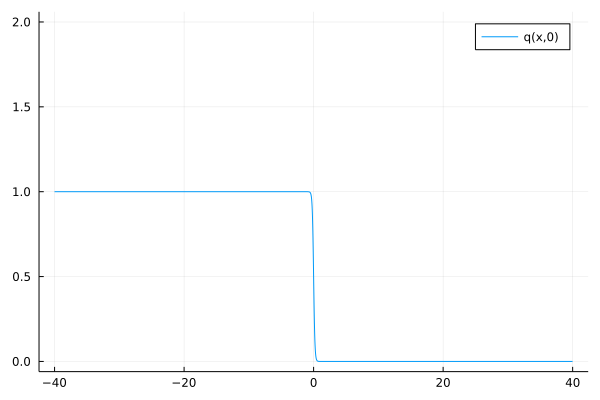

In [12]:
L = 40
m = 2^12
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0

# initial condition
func = x -> (1 .+ exp.(10*x)).^(-1)
f = func(X)
c_ = f[1]
plot(X,f, xaxis = [-L,L], yaxis = [0,2], label = "q(x,0)")
#savefig("fig6")

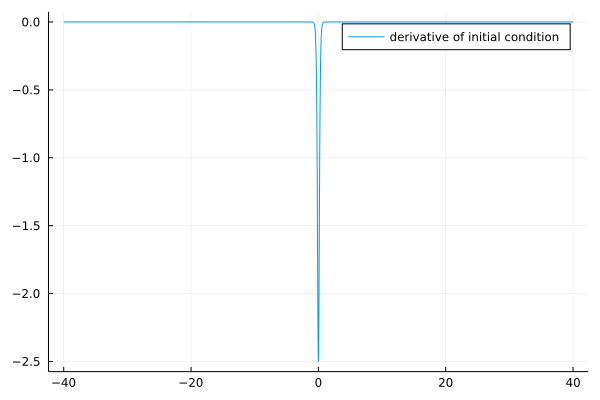

In [13]:
# derivative of initial condition
f_prime = -(10 * exp.(10 .* X)) ./ (1 .+ exp.(10 .* X)).^2
plot(X,f_prime, label = "derivative of initial condition")

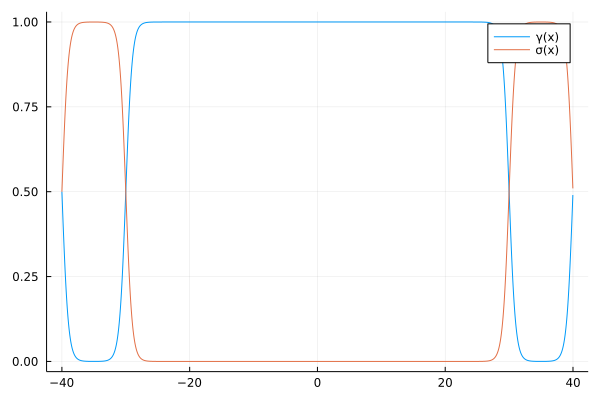

In [14]:
#damping
ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ1 = x -> (1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1)))
# make symmetric:
σ = x -> σ1(x) .+ σ1(-x)
γ = x -> 1 .- σ(-x) # should gamma be skinnier than sigma?

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
plot(X,γ(X),label = "γ(x)")
plot!(X,σ(X),label = "σ(x)")

168.709730 seconds (25.01 M allocations: 178.976 GiB, 10.46% gc time, 0.28% compilation time)


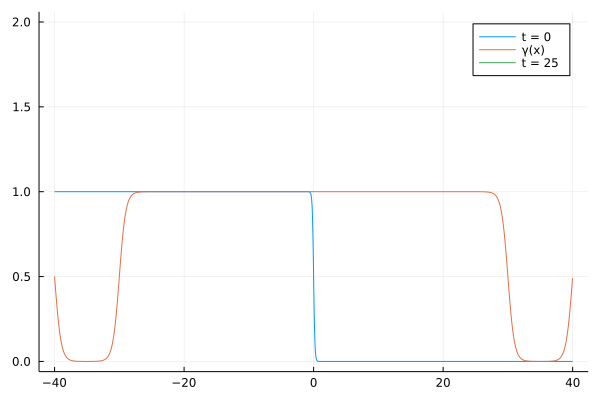

In [15]:
c = mfft(f_prime)
dt = 0.001
T = 25
t = 0.0
fr = 100 #frames/unit time
steps = convert(Int64,ceil(T/dt))
tb = convert(Int64,ceil(steps/(fr*T)))
ϵ = 10^(-1.5)

D3_dt = exp(ϵ^2 * D.^3 * dt)
D3_3dt2 = exp(ϵ^2 * D.^3 * (3*dt/2))
D3_2dt = exp(ϵ^2 * D.^3 * (2*dt))
iD3_dt = exp(-ϵ^2 * D.^3 * dt)
iD3_3dt2 = exp(-ϵ^2 * D.^3 * (3*dt/2))
iD3_2dt = exp(-ϵ^2 * D.^3 * (2*dt))
Mats = [D3_dt,D3_3dt2,D3_2dt,iD3_dt,iD3_3dt2,iD3_2dt]

D3_dt = exp(ϵ^2 * D.^3 * dt/2)
D3_3dt2 = exp(ϵ^2 * D.^3 * (3*dt/4))
D3_2dt = exp(ϵ^2 * D.^3 * (dt))
iD3_dt = exp(-ϵ^2 * D.^3 * dt/2)
iD3_3dt2 = exp(-ϵ^2 * D.^3 * (3*dt/4))
iD3_2dt = exp(-ϵ^2 * D.^3 * (dt))
Mats1 = [D3_dt,D3_3dt2,D3_2dt,iD3_dt,iD3_3dt2,iD3_2dt]

y_low = 0
y_up = 2
x_low = -L
x_up = L

@time begin
    
for i = 1:steps 
    #=  
    a = rk4(c,Mats1,dt/2)
    c_til = Mats1[4] * a
    c_bar = CG(B, A(c_til), 1e-10)
    a = rk4(c_bar,Mats1,dt/2)
    c = Mats1[4] * a=#
        
    a = rk4(c,Mats,dt)
    c = Mats[4] * a    
    t += dt
    #=
    if isinteger(i / 1000)
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end=#
end
    
end

plot(X, f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 0")
plot!(X,γ(X),label = "γ(x)")
plot!(X, integrate(c) |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 25")

## Plotting on a new grid

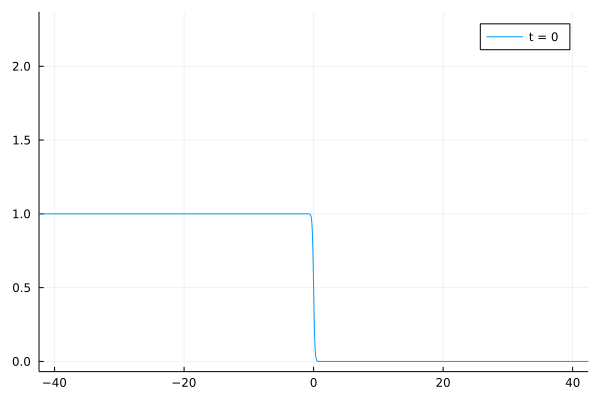

In [137]:
plot(X, f, xaxis = [-40,40], yaxis = [0,2.3], label = "t = 0")

In [138]:
# defining new grid
m = 2^15
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0

0.0

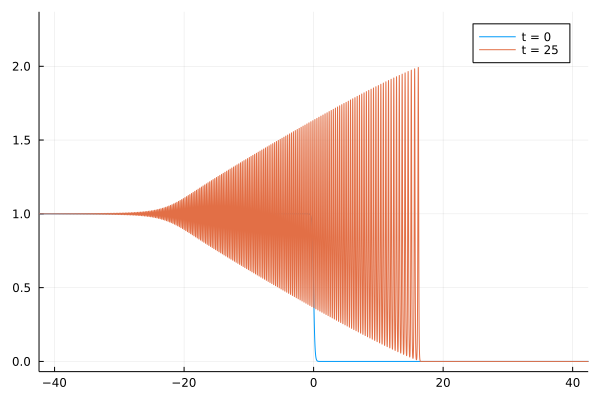

In [139]:
fm = trig_interp(L,c)
new_df = map(fm,X)
c_new = mfft(new_df)
plot!(X, integrate(c_new) |> real, xaxis = [-40,40], yaxis = [0,2.3], label = "t = 25")

In [140]:
savefig("fig8")

In [84]:
c_new |> Array

16384-element Vector{ComplexF64}:
  3.3224978324142285e-11 - 6.42828769815279e-11im
  -2.043520908046048e-11 - 7.156586434575729e-11im
    -6.8098415795248e-11 - 4.672529030358419e-11im
  -8.192557743313955e-11 - 3.143085791634803e-11im
 -5.7191584801330464e-11 - 3.3224978324142285e-11im
  -1.716671249596402e-11 - 3.360867140145274e-11im
   4.689582056016661e-13 - 2.1309176645445405e-11im
 -1.6342482922482304e-11 - 1.0082601420435822e-11im
  -3.999289788225724e-11 - 1.9184653865522705e-13im
 -4.3218761902608094e-11 + 1.5496937066927785e-11im
 -1.5347723092418164e-11 + 2.9757529773632996e-11im
   2.567901447037002e-11 + 3.4290792427782435e-11im
   4.518341256698477e-11 + 2.9403590673382496e-11im
                         ⋮
  5.5280224842135794e-11 - 3.0461855260455195e-11im
   1.411137873219559e-11 - 4.5769610323986853e-11im
  -5.707434524993005e-11 - 2.397371190454578e-11im
  -9.584688598351931e-11 + 2.638245177877252e-11im
  -7.643663479939278e-11 + 5.3940851785228006e-11im
 -2.7178259

In [40]:
y_up = 2
x_low = -40
x_up = 40
plot(X, f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 0")
plot!(X,γ(X),label = "γ(x)")
plot!(X, integrate(c) |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 25")
savefig("fig9")

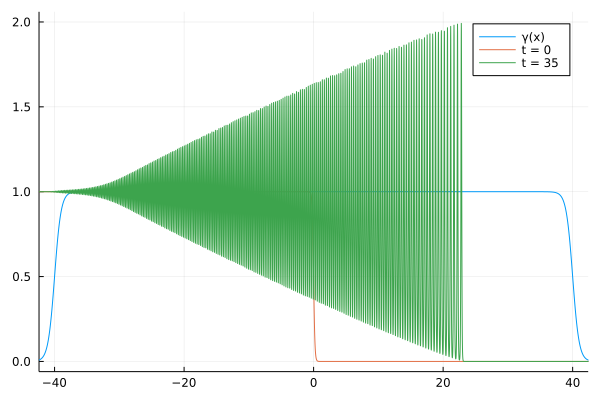

In [81]:
plot(X, γ(X), xaxis = [-40,40], yaxis = [0,2], label = "γ(x)")
#plot(X,σ(X), xaxis = [-40,40], yaxis = [0,2], label = "σ(x)")
plot!(X, f, xaxis = [-40,40], yaxis = [0,2], label = "t = 0")
plot!(X, integrate(c) |> real, xaxis = [-40,40], yaxis = [0,2], label = "t = 35")

## Staircase IC